In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
#from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

In [16]:
data = pd.read_csv("/Users/guapofish/Desktop/UPRO.csv")

In [17]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-06-25,2.252500,2.420833,2.252500,2.411111,2.349119,1288800
1,2009-06-26,2.390556,2.426111,2.354722,2.398611,2.336941,6552000
2,2009-06-29,2.416667,2.472222,2.382778,2.466667,2.403246,4345200
3,2009-06-30,2.466667,2.486667,2.352778,2.407778,2.345871,8564400
4,2009-07-01,2.436944,2.505833,2.427222,2.433611,2.371040,6019200


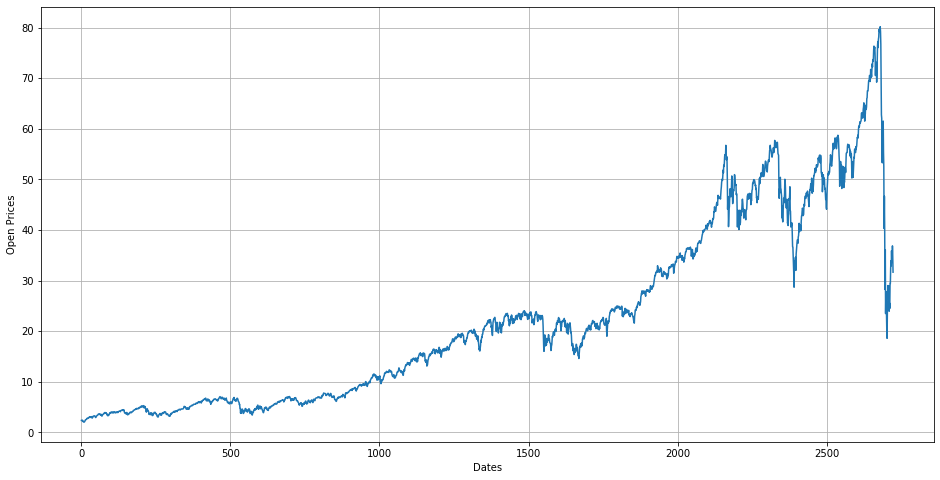

In [18]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Adj Close']);

No handles with labels found to put in legend.


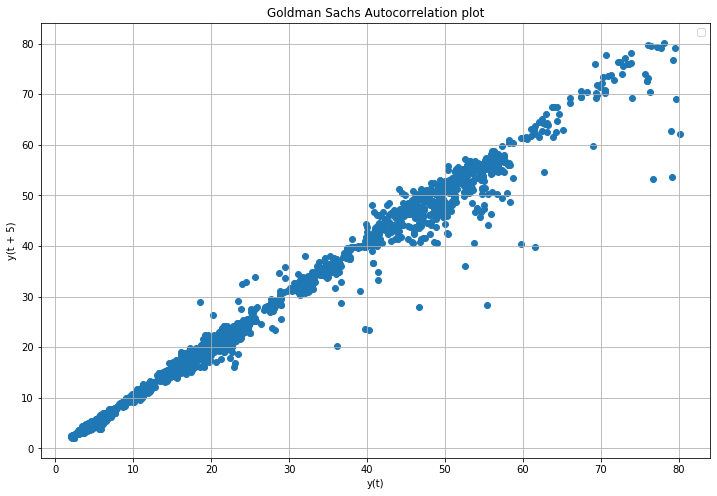

In [19]:
plt.figure(figsize=(12,8))
lag_plot(data['Adj Close'], lag=5)
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend();

/Users/guapofish/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


<Figure size 1152x576 with 0 Axes>

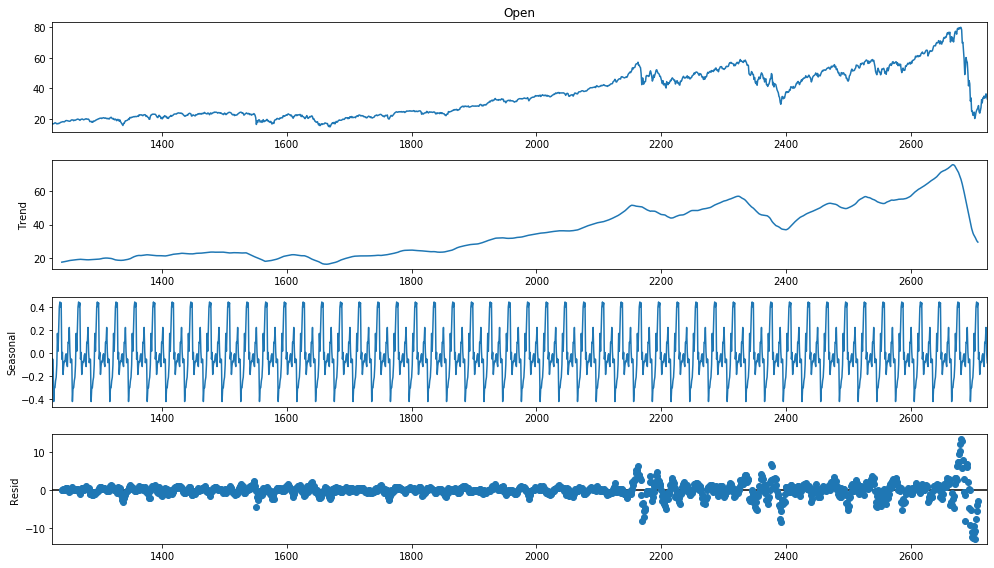

In [20]:
#rcParams['figure.figsize'] = 14, 8
rcParams['figure.figsize'] = 14, 8
data_arima = data['Open']
result = seasonal_decompose(data_arima[-1500:], model='additive', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

In [21]:
values = DataFrame(data['Open'].values)
dataframe = concat([values,values.shift(1),values.shift(5),values.shift(10),values.shift(30)], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.998854  0.993700  0.985365  0.950331
t+1   0.998854  1.000000  0.995052  0.987071  0.951790
t+5   0.993700  0.995052  1.000000  0.993711  0.957804
t+10  0.985365  0.987071  0.993711  1.000000  0.966674
t+30  0.950331  0.951790  0.957804  0.966674  1.000000


# Train and Test split 

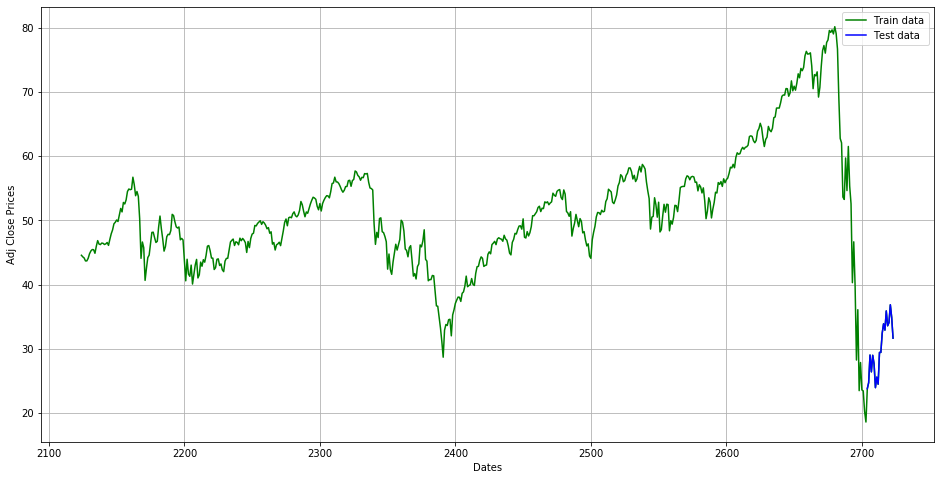

In [22]:
train_data, test_data = data[0:-20], data[-20:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Adj Close Prices')
plt.plot(data['Adj Close'].tail(600), 'green', label='Train data')
plt.plot(test_data['Adj Close'], 'blue', label='Test data')
plt.legend()

In [23]:
mean_value = data['Adj Close'].mean() # calculation of mean price

print('MSE: '+str(mean_squared_error(test_data['Adj Close'], np.full(len(test_data), mean_value))))
print('MAE: '+str(mean_absolute_error(test_data['Adj Close'], np.full(len(test_data), mean_value))))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['Adj Close'], np.full(len(test_data), mean_value)))))

MSE: 73.21665417658289
MAE: 7.4930587707048435
RMSE: 8.556673078748707


# LSTM

In [24]:
train = train_data['Adj Close'].values.reshape(-1,1) # selecting open prices
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 


In [25]:
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

In [26]:
import tensorflow as tf

model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])


# Fitting the RNN to the Training set

model.fit(X_train, y_train, epochs=5, batch_size = 5)

Epoch 1/5
2697/2697 [==============================] - 4s 1ms/step - loss: 0.0036 - accuracy: 7.4156e-04
Epoch 2/5
2697/2697 [==============================] - 3s 1ms/step - loss: 0.0018 - accuracy: 7.4156e-04
Epoch 3/5
2697/2697 [==============================] - 3s 1ms/step - loss: 0.0016 - accuracy: 7.4156e-04
Epoch 4/5
2697/2697 [==============================] - 3s 1ms/step - loss: 0.0014 - accuracy: 7.4156e-04
Epoch 5/5
2697/2697 [==============================] - 4s 1ms/step - loss: 0.0011 - accuracy: 7.4156e-04


In [27]:
'''
def batch_size(batch_s):
    
    model.fit(X_train, y_train, epochs=5, batch_size = batch_s, callbacks=[callbacks])
    
    # this will be used later while comparing and visualization
    real_stock_price = test_data['Adj Close'].values.reshape(-1,1) # taking open price
    # combine original train and test data vertically
    # as previous Open Prices are not present in test dataset
    # e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
    combine = pd.concat((train_data['Adj Close'], test_data['Adj Close']), axis = 0)
    # our test inputs also contains stock open Prices of last timesteps dates (as described above)
    test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
    test_inputs = test_inputs.reshape(-1,1)
    test_inputs = scaler.transform(test_inputs)

    # same steps as we followed while processing training data
    X_test = []
    for i in range(timesteps, test_data.shape[0]+timesteps):
        X_test.append(test_inputs[i-timesteps:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = model.predict(X_test)
    # inverse_transform because prediction is done on scaled inputs
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

    mse = mean_squared_error(real_stock_price, predicted_stock_price)
    print('MSE of batch size ' + str(batch_s) +str(mse))
    mae = mean_absolute_error(real_stock_price, predicted_stock_price)
    print('MAE of batch size ' + str(batch_s) +str(mae))
    rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    print('RMSE of batch size ' + str(batch_s) +str(rmse))

'''


"\ndef batch_size(batch_s):\n    \n    model.fit(X_train, y_train, epochs=5, batch_size = batch_s, callbacks=[callbacks])\n    \n    # this will be used later while comparing and visualization\n    real_stock_price = test_data['Adj Close'].values.reshape(-1,1) # taking open price\n    # combine original train and test data vertically\n    # as previous Open Prices are not present in test dataset\n    # e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  \n    combine = pd.concat((train_data['Adj Close'], test_data['Adj Close']), axis = 0)\n    # our test inputs also contains stock open Prices of last timesteps dates (as described above)\n    test_inputs = combine[len(combine) - len(test_data) - timesteps:].values\n    test_inputs = test_inputs.reshape(-1,1)\n    test_inputs = scaler.transform(test_inputs)\n\n    # same steps as we followed while processing training data\n    X_test = []\n    for i in range(timesteps, t

In [28]:
# this will be used later while comparing and visualization
real_stock_price = test_data['Adj Close'].values.reshape(-1,1) # taking open price
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Adj Close'], test_data['Adj Close']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [29]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

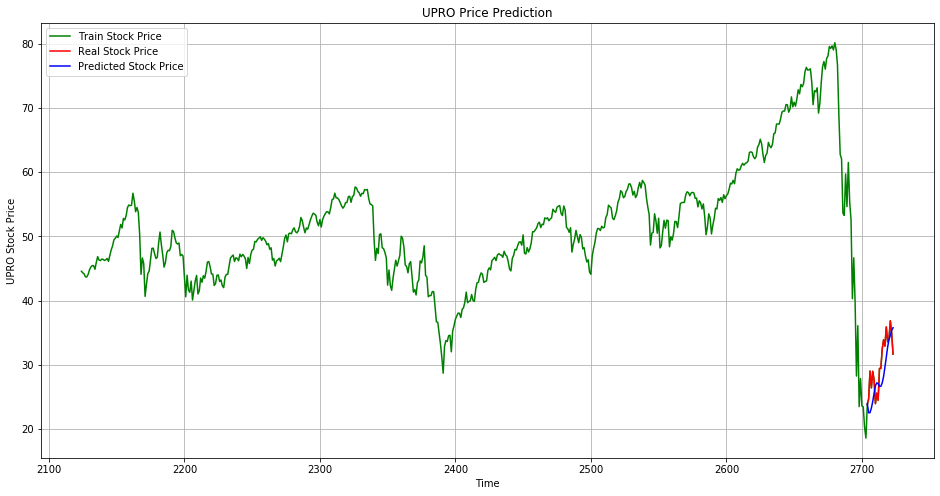

MSE: 11.65570226867387
MAE: 2.915631457763671
RMSE: 3.4140448545199096


In [30]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Adj Close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('UPRO Price Prediction')
plt.xlabel('Time')
plt.ylabel('UPRO Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))
